In [1]:
from SALib.sample import saltelli, sobol
from SALib.analyze import sobol
import numpy as np
import numba
import multiprocessing as mp

import time
from math import sin, cos, tan

## 1. Проведите анализ чувствительности, проверьте сходимость, измерьте тайминги

In [17]:
N = 2**15

problem = {
    'num_vars': 3,
    'names': ['x1', 'x2', 'x3'],
    'bounds': [[-3.14159265359, 3.14159265359],
               [-3.14159265359, 3.14159265359],
               [-3.14159265359, 3.14159265359]]
}

In [18]:
def model(x):
    val = sin(x[0])**2 + cos(x[1] + x[2]**2) + x[0] * tan(x[2])
    return val

In [19]:
def analize_model(problem, func, parallel):
    start_time = time.time()    
    param_values = saltelli.sample(problem, N)
    end_time_sample = time.time() - start_time
    
    Y = np.zeros([param_values.shape[0]])
    
    start_time = time.time()
    for i, X in enumerate(param_values):
        Y[i] = func(X)
    end_time_func = time.time() - start_time
    
    start_time = time.time()
    Si = sobol.analyze(problem, Y, parallel=parallel, print_to_console=True)
    end_time_si = time.time() - start_time
    
    print("#"*50)
    print(f"\nВремя генерации данных == {end_time_sample}")
    print(f"Время расчета значений ф-и == {end_time_func}")
    print(f"Время анализа Соболя == {end_time_si}\n")
    print("#"*50)
    
    Si.plot()
    return end_time_sample, end_time_func, end_time_si
        

/tmp/ipykernel_8911/1330849106.py:3: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, N)


          ST   ST_conf
x1  0.571534  0.437476
x2  0.000009  0.000008
x3  0.938805  0.616833
          S1   S1_conf
x1 -0.000670  0.000922
x2  0.000004  0.000042
x3 -0.322019  0.359459
                S2   S2_conf
(x1, x2) -0.000007  0.000747
(x1, x3)  1.221962  1.194846
(x2, x3)  0.000049  0.000063
##################################################

Время генерации данных == 0.9886319637298584
Время расчета значений ф-и == 0.265491247177124
Время анализа Соболя == 1.4560034275054932

##################################################


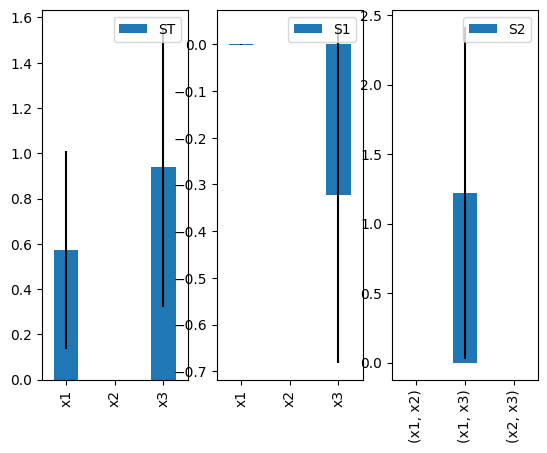

In [20]:
end_time_sample_classic, end_time_func_classic, end_time_si_classic = (
    analize_model(problem, model, parallel=False)
)

### 2. Ускорьте вычисления Python с использованием любой  из имеющихся возможностей (PyBind11, ctypes, cython, numba)

In [21]:
@numba.njit
def model_numba(x):
    val = sin(x[0])**2 + cos(x[1] + x[2]**2) + x[0] * tan(x[2])
    return val

/tmp/ipykernel_8911/1330849106.py:3: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, N)


          ST   ST_conf
x1  0.571534  0.496839
x2  0.000009  0.000010
x3  0.938805  0.973439
          S1   S1_conf
x1 -0.000670  0.001188
x2  0.000004  0.000053
x3 -0.322019  0.502111
                S2   S2_conf
(x1, x2) -0.000007  0.000890
(x1, x3)  1.221962  2.267436
(x2, x3)  0.000049  0.000092
##################################################

Время генерации данных == 0.9832592010498047
Время расчета значений ф-и == 0.17337942123413086
Время анализа Соболя == 1.4463698863983154

##################################################


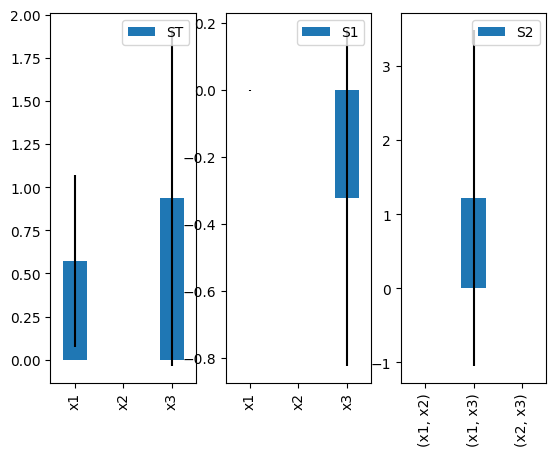

In [22]:
end_time_sample_numba, end_time_func_numba, end_time_si_numba = (
    analize_model(problem, model_numba, parallel=False)
)

In [25]:
print("Классика - ", end_time_sample_classic, end_time_func_classic, end_time_si_classic)
print("Numba - ", end_time_sample_numba, end_time_func_numba, end_time_si_numba)
print(
    f"""
    Улучшение:
    1. Генерация данных: {end_time_sample_classic / end_time_sample_numba},
    2. Расчет значений ф-ии: {end_time_func_classic/ end_time_func_numba}, 
    3. Анализ Соболя: {end_time_si_classic / end_time_si_numba}
    """
)

Классика -  0.9886319637298584 0.265491247177124 1.4560034275054932
Numba -  0.9832592010498047 0.17337942123413086 1.4463698863983154

    Улучшение:
    1. Генерация данных: 1.005464238396465,
    2. Расчет значений ф-ии: 1.5312731193086966, 
    3. Анализ Соболя: 1.0066604961827343
    


### с помощью numba смогли улучшить время вычисления ф-и в 50%.

### 3. Попробуйте добавить параллелизм в вычисления

In [26]:
def mp_classic(args):
    (problem, count_samples, i) = args
    val = saltelli.sample(problem, count_samples, i * count_samples)
    return val

In [27]:
def func_mp(problem, count_samples):
    count_process = 12
    count = count_samples // count_process
    ans = []
    with mp.Pool(count_process) as p:
        ans = p.map(
            mp_classic, 
            [
                (problem, count, i+1) for i in range(count_process)
            ]
        )
    return ans

start_time = time.time()
ans = func_mp(problem=problem, count_samples=N)
end_time_mp = time.time() - start_time
print(f"Время генерации с MP == {end_time_mp}")
print(f"Время генерации классическое == {end_time_sample_classic}")
print(f"Ускорение в {end_time_sample_classic / end_time_mp}")

/tmp/ipykernel_8911/658530095.py:3: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  val = saltelli.sample(problem, count_samples, i * count_samples)
/tmp/ipykernel_8911/658530095.py:3: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  val = saltelli.sample(problem, count_samples, i * count_samples)
/tmp/ipykernel_8911/658530095.py:3: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  val = saltelli.sample(problem, count_samples, i * count_samples)
/tmp/ipykernel_8911/658530095.py:3: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  val = saltelli.sample(problem, count_samples, i * count_samples)
/tmp/ipykernel_8911/658530095.py:3: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  val = saltelli.sampl

Время генерации с MP == 0.3510897159576416
Время генерации классическое == 0.9886319637298584
Ускорение в 2.815895535513593


### параллельный анализ

/tmp/ipykernel_8911/1330849106.py:3: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, N)


          ST   ST_conf
x1  0.571534  0.541043
x2  0.000009  0.000008
x3  0.938805  0.631561
          S1   S1_conf
x1 -0.000670  0.000932
x2  0.000004  0.000039
x3 -0.322019  0.363276
                S2   S2_conf
(x1, x2) -0.000007  0.000637
(x1, x3)  1.221962  1.221654
(x2, x3)  0.000049  0.000063
##################################################

Время генерации данных == 0.9678113460540771
Время расчета значений ф-и == 0.24657082557678223
Время анализа Соболя == 0.8790984153747559

##################################################


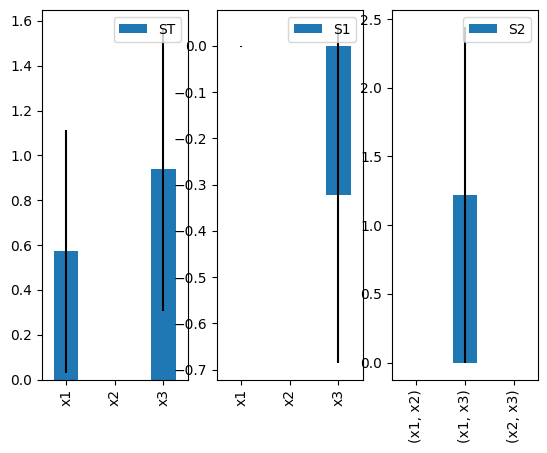

In [28]:
end_time_sample_parall, end_time_func_parall, end_time_si_parall = (
    analize_model(problem, model, parallel=True)
)

In [30]:
print(    
    f"""
    Улучшение:
    1. Генерация данных: {end_time_sample_classic / end_time_sample_parall},
    2. Расчет значений ф-ии: {end_time_func_classic / end_time_func_parall}, 
    3. Анализ Соболя: {end_time_si_classic / end_time_si_parall}
    """
)
print(end_time_sample_classic, end_time_func_classic, end_time_si_classic)


    Улучшение:
    1. Генерация данных: 1.0215130952542253,
    2. Расчет значений ф-ии: 1.0767342265902013, 
    3. Анализ Соболя: 1.6562462200376111
    
0.9886319637298584 0.265491247177124 1.4560034275054932


Прирост в 65% при анализе Соболя